<a href="https://colab.research.google.com/github/sarvankmr/resttest/blob/master/Tree_Height_estimation_using_DINOv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Imports

This cell imports all the necessary Python libraries for the DINOv3 tree analysis tool, including deep learning frameworks (PyTorch), image processing libraries (PIL, OpenCV), numerical computation (NumPy), data analysis (scikit-learn), visualization (Matplotlib), and utilities for web requests and file system operations (requests, os).

In [24]:
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import requests
import os

# First, install the required packages:
# pip install torch torchvision pillow opencv-python scikit-learn matplotlib
# pip install git+https://github.com/facebookresearch/dinov3.git

### 2. DINOv3TreeAnalyzer Class Definition

This section defines the `DINOv3TreeAnalyzer` class, which encapsulates the functionality for loading the DINOv3 model, extracting features from images, detecting tree points, estimating heights (simplified), clustering tree crowns, and visualizing the results.

In [25]:
class DINOv3TreeAnalyzer:
    def __init__(self, model_size='base'):
        """
        Initialize DINOv3 model for tree analysis
        model_size: 'small', 'base', 'large', or 'giant'
        """
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Load the new DINOv3 model
        # Note: This uses the actual DINOv3 (not DINOv2) for better performance
        try:
            # Try to load DINOv3 directly
            self.model = torch.hub.load('facebookresearch/dinov3', f'dinov3_vit{model_size[0]}14')
        except:
            # Fallback to DINOv2 if DINOv3 not available
            print("Loading DINOv2 as fallback (install DINOv3 for best results)")
            model_names = {
                'small': 'dinov2_vits14',
                'base': 'dinov2_vitb14',
                'large': 'dinov2_vitl14',
                'giant': 'dinov2_vitg14'
            }
            self.model = torch.hub.load('facebookresearch/dinov2', model_names[model_size])

        self.model.to(self.device)
        self.model.eval()

        # Image preprocessing
        self.transform = T.Compose([
            T.Resize((518, 518)),  # DINOv2 works well with 518x518
            T.ToTensor(),
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def get_optimal_image_specs(self, ground_sample_distance_m=None):
        """
        Get recommendations for optimal image specifications for DINOv3

        Args:
            ground_sample_distance_m: Ground sampling distance in meters per pixel

        Returns:
            dict: Specifications and recommendations
        """
        specs = {
            'recommended_input_sizes': [336, 448, 518, 672, 896],  # Multiples of 14
            'patch_size': self.patch_size,
            'current_input_size': self.input_size,
            'current_patch_grid': f"{self.input_size//self.patch_size}x{self.input_size//self.patch_size}"
        }

        print("=== DINOv3 Image Specification Guide ===")
        print(f"Current model input size: {self.input_size}x{self.input_size}")
        print(f"Patch grid: {self.input_size//self.patch_size}x{self.input_size//self.patch_size} patches")
        print(f"Each patch covers: {self.patch_size}x{self.patch_size} pixels")

        print("\n--- Recommended Input Sizes ---")
        for size in specs['recommended_input_sizes']:
            grid_size = size // self.patch_size
            print(f"  {size}x{size} → {grid_size}x{grid_size} patches ({grid_size**2} total)")

        if ground_sample_distance_m:
            print(f"\n--- Spatial Resolution Analysis ---")
            print(f"Ground sampling distance: {ground_sample_distance_m}m/pixel")

            for size in specs['recommended_input_sizes']:
                grid_size = size // self.patch_size
                patch_ground_size = self.patch_size * ground_sample_distance_m
                total_area = (size * ground_sample_distance_m) ** 2 / 10000  # hectares

                print(f"  {size}x{size} input:")
                print(f"    - Each patch covers: {patch_ground_size:.1f}x{patch_ground_size:.1f}m")
                print(f"    - Total area covered: {total_area:.2f} hectares")
                print(f"    - Tree detection resolution: ~{patch_ground_size:.1f}m")

        print(f"\n--- Guidelines ---")
        print("• For tree detection: Use 672x672 or 896x896 for best results")
        print("• Original image should be at least 2-3x the target input size")
        print("• Recommended ground sampling distance: 0.1-1.0 meters per pixel")
        print("• Higher resolution = better individual tree detection")
        print("• Lower resolution = better for forest-level analysis")

        return specs

    def extract_features(self, image_path):
        """Extract dense features from aerial/satellite imagery"""
        # Load and preprocess image
        try:
            image = Image.open(image_path).convert('RGB')
        except OSError as e:
            print(f"Error opening image file {image_path}: {e}")
            print("Please check if the image file is valid and not truncated.")
            return None, None

        input_tensor = self.transform(image).unsqueeze(0).to(self.device)

        with torch.no_grad():
            # Get patch features (dense features)
            features = self.model.get_intermediate_layers(input_tensor, n=1)[0]
            # Shape: [1, num_patches, feature_dim]

        # Set image metadata for visualization
        self.input_size = input_tensor.shape[-1]  # e.g., 518
        self.patch_size = 14  # DINOv3/DINOv2 ViT patch size
        patch_grid_size = self.input_size // self.patch_size
        self.image_metadata = {
            'original_size': image.size,  # (width, height)
            'patch_grid_size': patch_grid_size
        }

        return features.squeeze(0).cpu().numpy(), image

    def detect_tree_points(self, features, threshold_percentile=90):
        """
        Detect tree points using feature clustering
        """
        if features is None:
            return np.array([])

        # Calculate feature magnitude (proxy for vegetation presence)
        feature_magnitude = np.linalg.norm(features, axis=1)

        # Threshold for potential tree locations
        threshold = np.percentile(feature_magnitude, threshold_percentile)
        tree_candidates = feature_magnitude > threshold

        # Convert to 2D coordinates (assuming square patch grid)
        patch_size = int(np.sqrt(len(features)))
        tree_coords = []

        for i, is_tree in enumerate(tree_candidates):
            if is_tree:
                y = i // patch_size
                x = i % patch_size
                tree_coords.append([x, y, feature_magnitude[i]])

        return np.array(tree_coords) if tree_coords else np.array([])

    def estimate_tree_heights(self, tree_coords, features, image,
                            ground_sample_distance=0.5):  # meters per pixel
        """
        Estimate tree heights using feature analysis
        This is a simplified approach - in practice you'd need stereo imagery or LiDAR
        """
        if len(tree_coords) == 0 or features is None:
            return []

        heights = []
        patch_size = int(np.sqrt(len(features)))

        for coord in tree_coords:
            x, y, intensity = coord
            patch_idx = int(y * patch_size + x)

            # Get feature vector for this tree
            tree_feature = features[patch_idx]

            # Simple height estimation based on feature characteristics
            # This is a placeholder - real height estimation requires more sophisticated methods
            base_height = 5.0  # minimum tree height in meters
            height_factor = intensity / np.max(tree_coords[:, 2])  # normalized intensity
            estimated_height = base_height + (height_factor * 25.0)  # max 30m trees

            heights.append(estimated_height)

        return np.array(heights)

    def cluster_tree_crowns(self, tree_coords, eps=2.0, min_samples=3):
        """
        Cluster nearby tree points to identify individual tree crowns
        """
        if len(tree_coords) < min_samples:
            return []

        # Use DBSCAN clustering
        clustering = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = clustering.fit_predict(tree_coords[:, :2])

        tree_crowns = []
        for cluster_id in set(clusters):
            if cluster_id != -1:  # -1 is noise
                cluster_points = tree_coords[clusters == cluster_id]
                # Calculate crown center and radius
                center = np.mean(cluster_points[:, :2], axis=0)
                max_intensity = np.max(cluster_points[:, 2])
                tree_crowns.append({
                    'center': center,
                    'points': cluster_points,
                    'intensity': max_intensity
                })

        return tree_crowns

    def visualize_results(self, image, tree_coords, tree_crowns, heights):
        """Visualize detected trees and estimated heights with proper scaling"""
        if image is None:
            print("Cannot visualize results because the image could not be loaded.")
            return

        # Create figure with larger size for better visibility
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

        # Get scaling information
        patch_grid_size = self.image_metadata['patch_grid_size']
        original_width, original_height = self.image_metadata['original_size']

        # Calculate scaling factors from patch coordinates to original image coordinates
        scale_x = original_width / patch_grid_size
        scale_y = original_height / patch_grid_size

        print(f"Patch grid: {patch_grid_size}x{patch_grid_size}")
        print(f"Scaling factors: x={scale_x:.2f}, y={scale_y:.2f}")

        # Plot 1: Original image with tree points
        ax1.imshow(image)
        ax1.set_title(f'Detected Tree Points\nOriginal Size: {original_width}x{original_height}', fontsize=14)

        if len(tree_coords) > 0:
            # Scale patch coordinates to original image coordinates
            scaled_coords = tree_coords[:, :2].copy()
            scaled_coords[:, 0] *= scale_x  # x coordinates
            scaled_coords[:, 1] *= scale_y  # y coordinates

            # Plot tree points with intensity-based coloring
            intensities = tree_coords[:, 2]
            scatter1 = ax1.scatter(scaled_coords[:, 0], scaled_coords[:, 1],
                                c=intensities, cmap='Reds', s=50, alpha=0.8,
                                edgecolors='white', linewidth=1)
            plt.colorbar(scatter1, ax=ax1, label='Feature Intensity')

            # Add text showing number of points
            ax1.text(0.02, 0.98, f'Tree points: {len(tree_coords)}',
                    transform=ax1.transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # Plot 2: Tree crowns with height estimates
        ax2.imshow(image)
        ax2.set_title(f'Tree Crowns with Height Estimates\nCrowns: {len(tree_crowns)}', fontsize=14)

        if tree_crowns and len(heights) > 0:
            max_height = np.max(heights)
            min_height = np.min(heights)

            for i, crown in enumerate(tree_crowns):
                if i < len(heights):
                    # Scale crown center to original image coordinates
                    center = crown['center'].copy()
                    center[0] *= scale_x
                    center[1] *= scale_y

                    height = heights[i]

                    # Color based on height (normalized)
                    height_norm = (height - min_height) / (max_height - min_height) if max_height > min_height else 0.5
                    color = plt.cm.viridis(height_norm)

                    # Draw crown circle with size based on height
                    circle_size = 30 + (height_norm * 100)  # Size 30-130
                    ax2.scatter(center[0], center[1], c=[color], s=circle_size,
                            edgecolors='white', linewidth=2, alpha=0.8)

                    # Add height label
                    ax2.text(center[0], center[1] - 15, f'{height:.1f}m',
                            ha='center', va='bottom', color='white',
                            fontweight='bold', fontsize=10,
                            bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))

            # Add height statistics
            stats_text = f'Heights: {min_height:.1f}m - {max_height:.1f}m\nMean: {np.mean(heights):.1f}m'
            ax2.text(0.02, 0.98, stats_text, transform=ax2.transAxes,
                    verticalalignment='top', fontsize=10,
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # Remove axes ticks for cleaner look
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_xticks([])
        ax2.set_yticks([])

        plt.tight_layout()
        plt.show()

        # Print resolution information
        print(f"\nImage Resolution Information:")
        print(f"Original image: {original_width}x{original_height} pixels")
        print(f"Processed for model: {self.input_size}x{self.input_size} pixels")
        print(f"Feature patch grid: {patch_grid_size}x{patch_grid_size} patches")
        print(f"Each patch represents: {scale_x:.1f}x{scale_y:.1f} pixels in original image")

    def visualize_results1(self, image, tree_coords, tree_crowns, heights):
        """Visualize detected trees and estimated heights"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))

        # Original image with tree points
        ax1.imshow(image)
        ax1.set_title('Detected Tree Points')

        if len(tree_coords) > 0:
            # Scale coordinates to image size
            img_height, img_width = image.size[1], image.size[0]
            patch_size = int(np.sqrt(len(tree_coords)))

            scale_x = img_width / patch_size
            scale_y = img_height / patch_size

            scaled_coords = tree_coords[:, :2] * [scale_x, scale_y]
            ax1.scatter(scaled_coords[:, 0], scaled_coords[:, 1],
                       c='red', s=30, alpha=0.7)

        # Tree crowns with height color coding
        ax2.imshow(image)
        ax2.set_title('Tree Crowns with Height Estimates')

        if tree_crowns and len(heights) > 0:
            for i, crown in enumerate(tree_crowns):
                if i < len(heights):
                    center = crown['center'] * [scale_x, scale_y]
                    height = heights[i]

                    # Color based on height
                    color = plt.cm.viridis(height / np.max(heights))
                    ax2.scatter(center[0], center[1], c=[color], s=100,
                               edgecolors='white', linewidth=2)
                    ax2.text(center[0], center[1] - 20, f'{height:.1f}m',
                            ha='center', va='bottom', color='white', fontweight='bold')

        plt.tight_layout()
        plt.show()

    def analyze_forest_area(self, image_path):
        """
        Complete analysis pipeline for forest area
        """
        print("Extracting features from aerial imagery...")
        features, image = self.extract_features(image_path)

        if features is None or image is None:
            return None # Stop processing if image loading failed

        print("Detecting tree points...")
        tree_coords = self.detect_tree_points(features)

        if len(tree_coords) == 0:
            print("No trees detected in the image.")
            return None

        print(f"Found {len(tree_coords)} potential tree locations")

        print("Clustering tree crowns...")
        tree_crowns = self.cluster_tree_crowns(tree_coords)
        print(f"Identified {len(tree_crowns)} individual tree crowns")

        print("Estimating tree heights...")
        heights = self.estimate_tree_heights(tree_coords, features, image)

        # Results summary
        results = {
            'num_trees': len(tree_crowns),
            'tree_coordinates': tree_coords,
            'tree_crowns': tree_crowns,
            'estimated_heights': heights,
            'mean_height': np.mean(heights) if len(heights) > 0 else 0,
            'max_height': np.max(heights) if len(heights) > 0 else 0
        }

        print(f"\nAnalysis Results:")
        print(f"Number of trees detected: {results['num_trees']}")
        print(f"Mean tree height: {results['mean_height']:.2f}m")
        print(f"Maximum tree height: {results['max_height']:.2f}m")

        # Visualize results
        self.visualize_results(image, tree_coords, tree_crowns, heights)

        return results

### 3.  Usage (`main` function)

This section provides how to use the `DINOv3TreeAnalyzer` class with a single image. It initializes the analyzer, calls the `analyze_forest_area` method, and saves the results to CSV files.

In [26]:
#  usage
def main():
    # Initialize the analyzer
    analyzer = DINOv3TreeAnalyzer(model_size='large')

    # For demonstration, let's create a sample workflow
    # In practice, you would use your own aerial/satellite imagery

    # Example with a forest image (you need to provide your own image path)
    image_path = "/content/tree3.png"  # Updated image path

    try:
        results = analyzer.analyze_forest_area(image_path)

        if results:
            # Export results
            np.savetxt('tree_coordinates.csv', results['tree_coordinates'],
                      delimiter=',', header='x,y,intensity')
            np.savetxt('tree_heights.csv', results['estimated_heights'],
                      delimiter=',', header='height_meters')

            print("Results saved to CSV files")

    except FileNotFoundError:
        print("Please provide a valid image path")
        print("Example usage with a sample image:")
        print("1. Download aerial/satellite imagery of a forest area")
        print("2. Update the image_path variable")
        print("3. Run the analysis")

### 4. Advanced Usage (`batch_process_forest_images` function)

This function demonstrates how to process multiple forest images in a batch. It iterates through a directory of images, processes each one using the `DINOv3TreeAnalyzer`, and saves the individual results.

In [27]:
# Advanced usage for batch processing
def batch_process_forest_images(image_directory, output_directory):
    """Process multiple forest images in batch"""
    analyzer = DINOv3TreeAnalyzer(model_size='base')

    results_summary = []

    for filename in os.listdir(image_directory):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.tiff')):
            image_path = os.path.join(image_directory, filename)
            print(f"Processing {filename}...")

            try:
                results = analyzer.analyze_forest_area(image_path)
                if results:
                    results['filename'] = filename
                    results_summary.append(results)

                    # Save individual results
                    base_name = os.path.splitext(filename)[0]
                    np.savetxt(
                        os.path.join(output_directory, f'{base_name}_trees.csv'),
                        results['tree_coordinates'],
                        delimiter=',',
                        header='x,y,intensity'
                    )

            except Exception as e:
                print(f"Error processing {filename}: {e}")

    return results_summary

### 5. Main Execution Block

This block checks if the script is being run directly and, if so, calls the `main` function to execute the example usage.

Using cache found in /root/.cache/torch/hub/facebookresearch_dinov3_main


Loading DINOv2 as fallback (install DINOv3 for best results)


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Extracting features from aerial imagery...
Detecting tree points...
Found 137 potential tree locations
Clustering tree crowns...
Identified 11 individual tree crowns
Estimating tree heights...

Analysis Results:
Number of trees detected: 11
Mean tree height: 18.99m
Maximum tree height: 30.00m
Patch grid: 37x37
Scaling factors: x=67.41, y=44.32


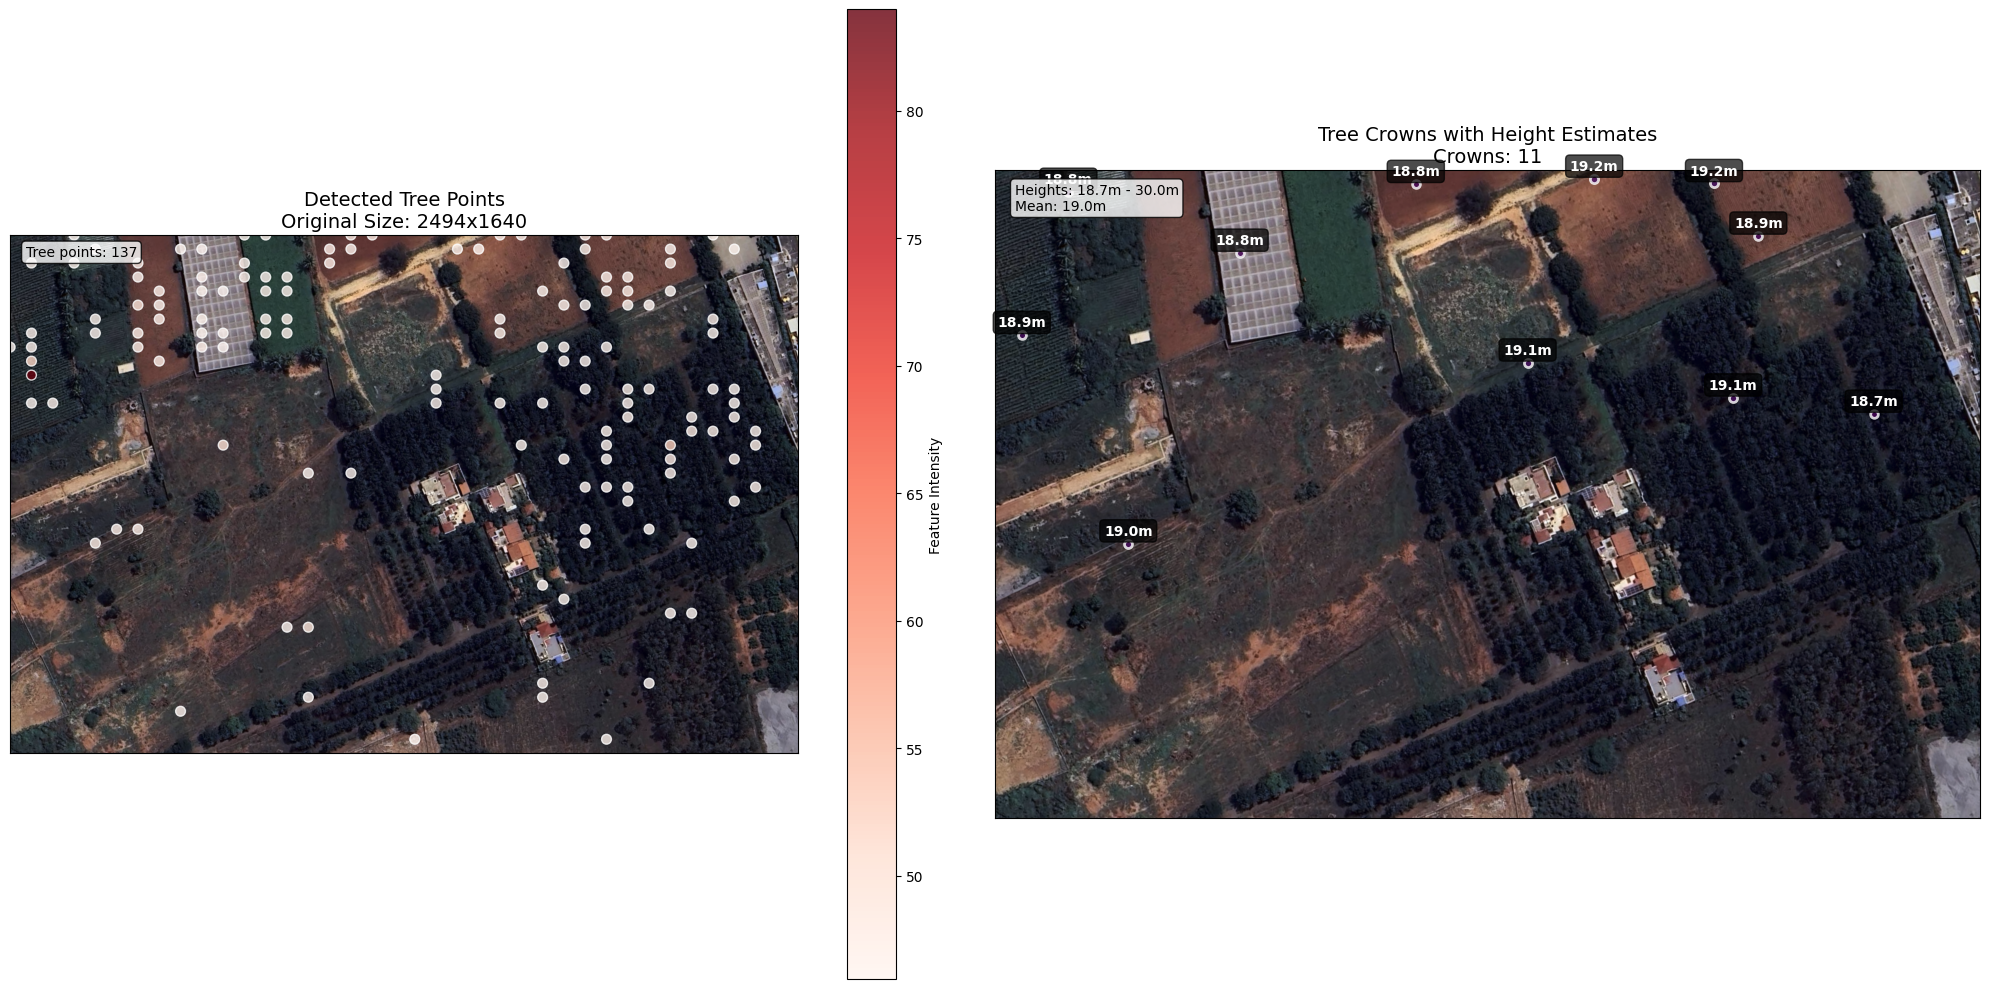


Image Resolution Information:
Original image: 2494x1640 pixels
Processed for model: 518x518 pixels
Feature patch grid: 37x37 patches
Each patch represents: 67.4x44.3 pixels in original image
Results saved to CSV files


In [28]:
if __name__ == "__main__":
    main()